# Training Facial Landmark Detection with Open CV

In [4]:
## Import Libraries
import cv2
import numpy as np
import dlib
import os
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET
import pandas as pd

## Helen DataSet

#### Download DataSet
Download the helen dataset from the following link: http://www.ifp.illinois.edu/~vuongle2/helen/ and place 'Helen/train_1', 'Helen/train_2', 'Helen/train_3', 'Helen/train_4' in the root directory.

#### Processing DataSet

In [5]:
# merge datasets
source_folders = ['Helen/train_1', 'Helen/train_2', 'Helen/train_3', 'Helen/train_4']
destination_folder = 'Helen/train'

# create dest folder locations
if not os.path.exists(destination_folder):
    os.mkdir(destination_folder)

# move files to one train file
for source_folder in source_folders:
    if os.path.exists(source_folder):
        # move to destination folder
        for image_path in os.listdir(source_folder):
            if '.jpg' in image_path:
                full_path = '/Users/IainMac/Desktop/Learning/Deep Learning/Project - Art/CariGANs/04 Facial Landmark Detection/pre-processing-pipeline/'
                old_path = os.path.join(full_path, source_folder, image_path)
                new_path = os.path.join(full_path, destination_folder, image_path)
                os.rename(old_path, new_path)
        # after all images have moved pathdelete original source_folder e.g. 'Helen/train_1'
        os.rmdir(source_folder)

## Facial Landmark Detection

## Resources:

This is the best resource you have found. Implementation is really quick and easy:
https://www.youtube.com/watch?v=MrRGVOhARYY

OpenCV basics:
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html

Training your own DLIB Model:

\https://stackoverflow.com/questions/46972906/how-to-detect-landmark-positions-from-caricature-faces

http://dlib.net/train_shape_predictor.py.html

https://medium.com/datadriveninvestor/training-alternative-dlib-shape-predictor-models-using-python-d1d8f8bd9f5c

https://medium.com/p/85e2f7a5e9eb/responses/show

Using a 3D model to extract the points required for dlib trianing:

https://github.com/codeniko/shape_predictor_81_face_landmarks

https://github.com/codeniko/eos

Helen Model:

https://www.dropbox.com/sh/t5h024w0xkedq0j/AABS3GprqIvb_PwqeHOn2dxNa?dl=0

## XML MetaData for Editing

#### Creating Landmarks MetaData File:

We want our landmarks that we generate to be as similar as possible to that used in the cariGAN paper. Further down the line we may experiment with using different landmarks to see if the cariGAN applies different deformations to the face. For now we are aiming for the landmarks to be as simlar as possible to those used in the paper. 

There are some pre-trained models avaliable online which we will utilise.

However, for some other points we will need to train our own models:
* density of points along the jawline
* points in the forehead
* centre eye point


### Helen Shape Predictor


In [2]:
def create_dlib_xml_helen(detector, source, save_string):
    '''
    predictor: .dat file used to predict images
    source: folder location of image files
    save_string: file name of new XML
    landmarks_new: dictionary mapping old landmarks labels to new landmarks labels
    '''
    not_processed = 0 
    progress = 0
    
    # initial xml dataStructure
    dataset_xml = ET.Element("dataset")
    name_xml = ET.SubElement(dataset_xml, "name")
    name_xml.text = 'dlib face detection dataset generated by ImgLab'
    comment_xml = ET.SubElement(dataset_xml, "comment")
    comment_xml.text = 'This dataset is manually crafted or adjusted using ImgLab web tool. Check more detail on https://github.com/NaturalIntelligence/imglab'
    images_xml = ET.SubElement(dataset_xml, "images")
    
    # for each text file (labels) in Helen/annotations
    for annotation_file in os.listdir('Helen/annotation'):
        
        progress += 1
         
        # strip line space character from each element of list
        lineList = [line.rstrip('\n') for line in open(os.path.join('Helen/annotation', annotation_file))]
        
        # image path file name without prefix is first line of points file
        image_path = lineList[0] + '.jpg'
        
        #  the list of coordinates are the remaining lines of the points file
        coordinate_list=[]

        for line in lineList[1:]:
            x = float(line.split(',')[0].rstrip())
            y = float(line.split(',')[1].rstrip())
            coordinate_list.append((x,y))
        
        # if image is in source e.g. in Helen/train
        if image_path in os.listdir(source):
        
            # read the image
            image = cv2.imread(os.path.join(source,image_path))

            # grayscale version of image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # detect faces in picture (There may be many faces)
            faces = detector(gray)

            # ignore any images with more than one face
            # this is because only one face per image is annotated in the helen dataset
            if len(faces) != 1:
                # do nothing
                not_processed += 1
            else:
                face = faces[0]
                
                # XML
                image_xml = ET.SubElement(images_xml, "image")
                image_xml.set('file', str(image_path))
                
                # extract co-ordinates of facial detector
                left = face.left()
                top = face.top()
                right = face.right()
                bottom = face.bottom()
                width = face.width()
                height = face.height()

                # XML: write facial box to xml ???
                box_xml = ET.SubElement(image_xml, "box")
                box_xml.set('top', str(top))
                box_xml.set('left', str(left))
                box_xml.set('width', str(width))
                box_xml.set('height', str(height))

                # XML: label for box
                label_xml = ET.SubElement(box_xml, "label")
                label_xml.text ='face'

                # plot the landmarks and overlay on image
                for coordinate_i, coordinate in enumerate(coordinate_list):
                    x = int(round(coordinate[0]))
                    y = int(round(coordinate[1]))
                    
                    # pad coordinate with zeros to preserve ordering of points
                    coordinate_i = str(coordinate_i)
                    coordinate_i = coordinate_i.zfill(3)

                    # XML: write coordinates to part tag
                    part_xml = ET.SubElement(box_xml, "part")
                    part_xml.set('name', coordinate_i)
                    part_xml.set('x', str(x))
                    part_xml.set('y', str(y))
                    
        if progress % 100 == 0:
            print('processed: ' + str(progress))
                    
    # save xml to source
    save = os.path.join(source, save_string)
    tree = ET.ElementTree(dataset_xml)
    tree.write(save)
    
    # these final two lines of code are to ensure the xml is in the dlib required format
    temp_xml = dlib.image_dataset_metadata.load_image_dataset_metadata(save)
    dlib.image_dataset_metadata.save_image_dataset_metadata(temp_xml, save)
    
    #
    print('files not processed: ' + str(not_processed))
      

In [33]:
# detector used to predict facial region
detector = dlib.get_frontal_face_detector()

processed_train = True
processed_test = True

if not processed_train:
    create_dlib_xml_helen(detector, 'Helen/train', "Helen_dlib_train.xml")
if not processed_test:
    create_dlib_xml_helen(detector, 'Helen/test', "Helen_dlib_test.xml")


processed: 100
processed: 200
processed: 300
processed: 400
processed: 500
processed: 600
processed: 700
processed: 800
processed: 900
processed: 1000
processed: 1100
processed: 1200
processed: 1300
processed: 1400
processed: 1500
processed: 1600
processed: 1700
processed: 1800
processed: 1900
processed: 2000
processed: 2100
processed: 2200
processed: 2300
files not processed: 307
processed: 100
processed: 200
processed: 300
processed: 400
processed: 500
processed: 600
processed: 700
processed: 800
processed: 900
processed: 1000
processed: 1100
processed: 1200
processed: 1300
processed: 1400
processed: 1500
processed: 1600
processed: 1700
processed: 1800
processed: 1900
processed: 2000
processed: 2100
processed: 2200
processed: 2300
files not processed: 56


In [2]:
print('Number of training examples: ' + str(len(os.listdir('Helen/train'))))
print('Number of testing examples: ' + str(len(os.listdir('Helen/test'))))

Number of training examples: 3696
Number of testing examples: 607


## Double Helen Training/Test Size:

We can effectively double our training set size by mirroring all the images and landmarks within, which should help with our training/test accuracy.


In [46]:
def create_dlib_xml_mirrored(source, save_string, xml_path, source_label_matching):
    '''
    source: folder location of image files
    save_string: file name of new XML
    xml_path: path to xml ot be mirrored
    ''' 
    # part XML to be mirrored
    tree = ET.parse(xml_path)
    root = tree.getroot()
    element_images = root.findall("images")[0]
    
    # initial xml dataStructure
    dataset_xml = ET.Element("dataset")
    name_xml = ET.SubElement(dataset_xml, "name")
    name_xml.text = 'dlib face detection dataset generated by ImgLab'
    comment_xml = ET.SubElement(dataset_xml, "comment")
    comment_xml.text = 'This dataset is manually crafted or adjusted using ImgLab web tool. Check more detail on https://github.com/NaturalIntelligence/imglab'
    images_xml = ET.SubElement(dataset_xml, "images")
    
    _mirror = True
    
    for i in range(2):
        if i == 1:
            _mirror = False
    
        for i in range(len(element_images.findall('image'))):
            # gather all image in images (1-many)
            element_image = element_images.findall('image')[i]
            image_path = element_image.items()[0][1]
            
            if _mirror:
                # extract attribute from XML
                image_xml = ET.SubElement(images_xml, "image")
                image_xml.set('file', str(image_path))   
                
            else:
                # define new image file name
                new_image_path = image_path.split(".")[0] + '_mirrored.' + image_path.split(".")[-1]
                
                # extract attribute from XML
                image_xml = ET.SubElement(images_xml, "image")
                image_xml.set('file', new_image_path) 

                # read the image
                image = cv2.imread(os.path.join(source,image_path))
                
                # mirror the image
                image_mirrored = cv2.flip(image, 1)

                # save mirrored image
                # save_string = image_path.split(".")[0] + '_mirrored.' + image_path.split(".")[-1] 
                #save_file = source
                #save = os.path.join(save_file, new_image_path)
                #cv2.imwrite(save, image_mirrored)
                

            for i in range(len(element_image.findall('box'))):
                # gather all faces in image (1-many)
                element_box = element_image.findall('box')[i]
                
                if _mirror:
                    # extract attributes from XML
                    top = int(element_box.items()[0][1])
                    left = int(element_box.items()[1][1])
                    width = int(element_box.items()[2][1])
                    height = int(element_box.items()[3][1])

                    # XML: write facial box to xml
                    box_xml = ET.SubElement(image_xml, "box")
                    box_xml.set('top', str(top))
                    box_xml.set('left', str(left))
                    box_xml.set('width', str(width))
                    box_xml.set('height', str(height))
                 
                else:
                    # extract attributes from XML
                    top = int(element_box.items()[0][1])
                    left = int(element_box.items()[1][1])
                    width = int(element_box.items()[2][1])
                    height = int(element_box.items()[3][1])
                    
                    # flip attributes based on vertical centre axis
                    w = image.shape[1]
                    right_old = left + width
                    left_new = ((w / 2) - right_old) * 2 + right_old
                    left = int(left_new)
                    
                    # XML: write facial box to xml
                    box_xml = ET.SubElement(image_xml, "box")
                    box_xml.set('top', str(top))
                    box_xml.set('left', str(left))
                    box_xml.set('width', str(width))
                    box_xml.set('height', str(height))

                # XML: label for box
                label_xml = ET.SubElement(box_xml, "label")
                label_xml.text ='face'
                

                for i in range(len(element_box.findall('part'))):
                    # gather all landmarks of the face (1-many)
                    element_part = element_box.findall('part')[i]

                    if _mirror:
                        # extract attributes from xml
                        new_label = int(element_part.items()[0][1])
                        x = int(element_part.items()[1][1])
                        y = int(element_part.items()[2][1])
                        
                        # pad coordinate with zeros to preserve ordering of points
                        new_label = str(new_label)
                        new_label = new_label.zfill(3)

                        # XML: write coordinates to part tag
                        part_xml = ET.SubElement(box_xml, "part")
                        part_xml.set('name', new_label)
                        part_xml.set('x', str(x))
                        part_xml.set('y', str(y))
                        
                    else:
                        # extract attributes from xml
                        new_label = int(element_part.items()[0][1])
                        x = int(element_part.items()[1][1])
                        y = int(element_part.items()[2][1])
                        
                        # flip coordinates on vertical axis
                        w = image.shape[1]
                        x_new = ((w / 2) - x) * 2 + x
                        x = int(x_new)
                        
                        # source label matching
                        new_label = source_label_matching[new_label]
                        
                        # pad coordinate with zeros to preserve ordering of points
                        new_label = str(new_label)
                        new_label = new_label.zfill(3)

                        # XML: write coordinates to part tag
                        part_xml = ET.SubElement(box_xml, "part")
                        part_xml.set('name', new_label)
                        part_xml.set('x', str(x))
                        part_xml.set('y', str(y))
                    
    # save xml to source
    save = os.path.join(source, save_string)
    tree = ET.ElementTree(dataset_xml)
    tree.write(save)
    
    # these final two lines of code are to ensure the xml is in the dlib required format
    temp_xml = dlib.image_dataset_metadata.load_image_dataset_metadata(save)
    dlib.image_dataset_metadata.save_image_dataset_metadata(temp_xml, save)

When mirroring we need to ensure that we reverse the facial landmarks appropriately. For example, 0 corresponds to the top of the face's right ear (their right not our right) and 40 to the top of the face's left ear. If we simply mirror the image without mirroring the landmarks, this will cause havoc when it comes to trianing our facial landmark detector.

The image below shows the landmarks within the helen dataset. 

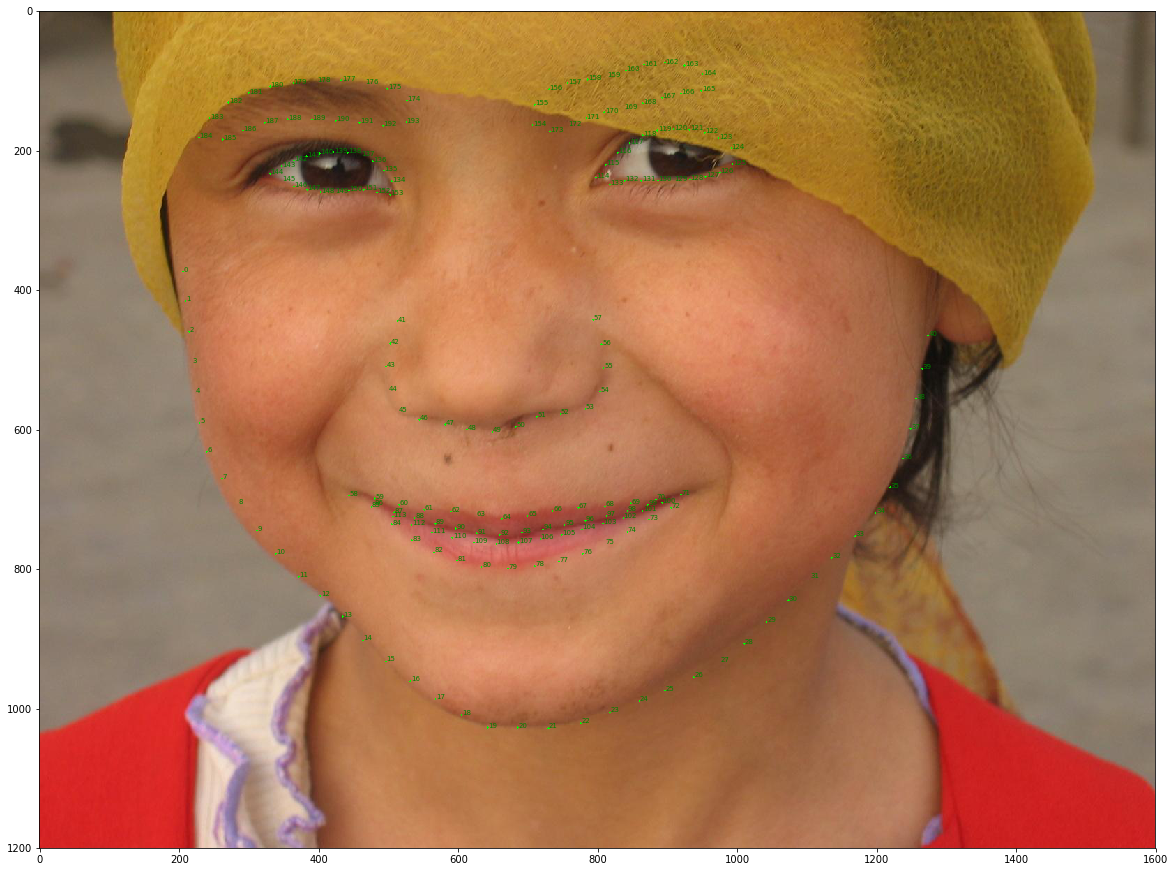

In [47]:
annotation_file = '284.txt'
image_path = '15024375_1.jpg'

# strip line space character from each element of list
lineList = [line.rstrip('\n') for line in open(os.path.join('Helen/annotation', annotation_file))]

# image path file name without prefix is first line of points file
image_path = lineList[0] + '.jpg'

#  the list of coordinates are the remaining lines of the points file
coordinate_list=[]

# read the image
image = cv2.imread(os.path.join('Helen/train',image_path))

for line_i, line in enumerate(lineList[1:]):
    x = int(round(float(line.split(',')[0].rstrip())))
    y = int(round(float(line.split(',')[1].rstrip())))
    coordinate_list.append((x,y))
    cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    
    
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20,20))
#plt.imshow(image);

for cood_i, cood in enumerate(coordinate_list):
    x,y = cood
    plt.text(x=x, y=y, s = str(cood_i), fontsize=7,color = 'green')
    
plt.imshow(image);

The dictionary below matches the landmarks on the left side of the face to the landmarks on the right side of the face. The landmarks in the centre of the face are matched to themselves. 

In [48]:
source_label_matching = {0: 40, 1: 39, 2: 38, 3: 37, 4: 36, 5: 35, 6: 34, 7: 33, 8: 32, 
                         9: 31, 10: 30, 11: 29, 12: 28, 13: 27, 14: 26, 15: 25, 16: 24, 
                         17: 23, 18: 22, 19: 21, 20: 20, 21: 19, 22: 18, 23: 17, 24: 16, 
                         25: 15, 26: 14, 27: 13, 28: 12, 29: 11, 30: 10, 31: 9, 32: 8, 
                         33: 7, 34: 6, 35: 5, 36: 4, 37: 3, 38: 2, 39: 1, 40: 0, 41: 57, 
                         42: 56, 43: 55, 44: 54, 45: 53, 46: 52, 47: 51, 48: 50, 49: 49, 
                         50: 48, 51: 47, 52: 46, 53: 45, 54: 44, 55: 43, 56: 42, 57: 41, 
                         58: 71, 59: 70, 60: 69, 61: 68, 62: 67, 63: 66, 64: 65, 65: 64, 
                         66: 63, 67: 62, 68: 61, 69: 60, 70: 59, 71: 58, 72: 85, 73: 84, 
                         74: 83, 75: 82, 76: 81, 77: 80, 78: 79, 79: 78, 80: 77, 81: 76, 
                         82: 75, 83: 74, 84: 73, 85: 72, 86: 100, 87: 99, 88: 98, 89: 97, 
                         90: 96, 91: 95, 92: 94, 93: 93, 94: 92, 95: 91, 96: 90, 97: 89, 
                         98: 88, 99: 87, 100: 86, 101: 113, 102: 112, 103: 111, 104: 110, 
                         105: 109, 106: 108, 107: 107, 108: 106, 109: 105, 110: 104, 
                         111: 103, 112: 102, 113: 101, 114: 134, 115: 135, 116: 136, 
                         117: 137, 118: 138, 119: 139, 120: 140, 121: 141, 122: 142, 
                         123: 143, 124: 144, 125: 145, 126: 146, 127: 147, 128: 148, 
                         129: 149, 130: 150, 131: 151, 132: 152, 133: 153, 134: 114, 
                         135: 115, 136: 116, 137: 117, 138: 118, 139: 119, 140: 120, 
                         141: 121, 142: 122, 143: 123, 144: 124, 145: 125, 146: 126, 
                         147: 127, 148: 128, 149: 129, 150: 130, 151: 131, 152: 132, 
                         153: 133, 154: 174, 155: 175, 156: 176, 157: 177, 158: 178, 
                         159: 179, 160: 180, 161: 181, 162: 182, 163: 183, 164: 184, 
                         165: 185, 166: 186, 167: 187, 168: 188, 169: 189, 170: 190, 
                         171: 191, 172: 192, 173: 193, 174: 154, 175: 155, 176: 156, 
                         177: 157, 178: 158, 179: 159, 180: 160, 181: 161, 182: 162, 
                         183: 163, 184: 164, 185: 165, 186: 166, 187: 167, 188: 168, 
                         189: 169, 190: 170, 191: 171, 192: 172, 193: 173}

In [49]:
# assert to check symmetry
for key in list(source_label_matching.keys()):
    assert source_label_matching[source_label_matching[key]] == key

In [50]:
# mirror dataset
is_mirrored_train = False
is_mirrored_test = False

if not is_mirrored_train:
    xml_path = os.path.join('Helen/train', "Helen_dlib_train.xml")
    create_dlib_xml_mirrored('Helen/train', "Helen_dlib_train_mirrored.xml", xml_path, source_label_matching)
    
if not is_mirrored_test:
    xml_path = os.path.join('Helen/test', "Helen_dlib_test.xml")
    create_dlib_xml_mirrored('Helen/test', "Helen_dlib_test_mirrored.xml", xml_path, source_label_matching)
 

In [51]:
print('Number of training examples: ' + str(len(os.listdir('Helen/train'))))
print('Number of testing examples: ' + str(len(os.listdir('Helen/test'))))

Number of training examples: 3696
Number of testing examples: 607


## Training your own DLIB Model:

\https://stackoverflow.com/questions/46972906/how-to-detect-landmark-positions-from-caricature-faces

http://dlib.net/train_shape_predictor.py.html

https://medium.com/datadriveninvestor/training-alternative-dlib-shape-predictor-models-using-python-d1d8f8bd9f5c

https://medium.com/p/85e2f7a5e9eb/responses/show

https://github.com/codeniko/shape_predictor_81_face_landmarks

#### Key Fields

* <b>Tree Depth</b> — Specifies the depth of the trees used in each cascade. This parameter represent the “capacity” of the model. An optimal value (in terms of accuracy) is 4, instead a value of 3 is a good tradeoff between accuracy and model-size.

* <b>Nu</b> — Is the regularization parameter. It determines the ability of the model to generalize and learn patterns instead of fixed-data. Value close to 1 will emphasize the learning of fixed-data instead of patterns, thus raising the chances for over-fitting to occur. Instead, an optimal nu value of 0.1 will make the model to recognize patterns instead of fixed-situations, totally eliminating the over-fitting problem. The amount of training samples can be a problem here, in fact with lower nu values the model needs a lot (thousands) of training samples in order to perform well.

* <b>Cascade Depth</b> — Is the number of cascades used to train the model. This parameter affect either the size and accuracy of a model. A good value is about 10-12, instead a value of 15 is a perfect balance of maximum accuracy and a reasonable model-size.

* <b>Feature Pool Size</b> — Denotes the number of pixels used to generate the features for the random trees at each cascade. Larger amount of pixels will lead the algorithm to be more robust and accurate but to execute slower. A value of 400 achieves a great accuracy with a good runtime speed. Instead, if speed is not a problem, setting the parameter value to 800 (or even 1000) will lead to superior precision. Interestingly, with a value between 100 and 150 is still possible to obtain a quite good accuracy but with an impressing runtime speed. This last value is particularly suitable for mobile and embedded devices applications.

* <b>Num Test Splits</b> — Is the number of split features sampled at each node. This parameter is responsible for selecting the best features at each cascade during the training process. The parameter affects the training speed and the model accuracy. The default value of the parameter is 20. This parameter can be very useful, for example, when we want to train a model with a good accuracy and keep its size small. This can be done by increasing the amount of num split test to 100 or even 300, in order to increase the model accuracy and not its size.

* <b>Oversampling Amount</b> — Specifies the number of randomly selected deformations applied to the training samples. Applying random deformations to the training images is a simple technique that effectively increase the size of the training dataset. Increasing the value of the parameter to 20 or even 40 is only required in the case of small datasets, also it will increase the training time considerably (so be careful). In the latest releases of the Dlib library, there is a new training parameter: the oversampling jittering amount that apply some translation deformation to the given bounding boxes in order to make the model more robust against eventually misplaced face regions.

### Strategy for Training DLIB Model:

We have a dillema. To have to manually annotate too many exmplaes will defeat the object of building the facial annotations model in the first place, since we need to use many annotated exmaples further downstream. 

Nu, oversampling amount, 

https://sourceforge.net/p/dclib/discussion/442518/thread/854c826e/?limit=25

Script which contains comments detailing training of model using a small data set: http://dlib.net/train_shape_predictor.py.html
Directory of jpg and xml files used to train this shape predictor:
https://github.com/davisking/dlib/tree/master/examples/faces


https://sourceforge.net/p/dclib/discussion/442518/thread/cbb22954/

### Training The Model

In [118]:
# benchmark error
model_dat = 'shape_predictor_68_face_landmarks.dat'

train_xml = 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'
test_xml = 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml'

measure_model_error(model_dat, train_xml)
measure_model_error(model_dat, test_xml)

Error of the model: shape_predictor_68_face_landmarks.dat is 6.8888672656038965
Error of the model: shape_predictor_68_face_landmarks.dat is 6.204732789912478


In [53]:
options = dlib.shape_predictor_training_options()
options.cascade_depth=20
options.be_verbose = True

model_dat = 'model.dat'

train_xml = os.path.join('Helen/train', "Helen_dlib_train_mirrored.xml")

dlib.train_shape_predictor(train_xml, model_dat, options)

In [54]:
_models = ['shape_predictor_194_face_landmarks.dat', 'model.dat']

for model in _models:
    train_xml = os.path.join('Helen/train', "Helen_dlib_train_mirrored.xml")
    test_xml = os.path.join('Helen/test', "Helen_dlib_test_mirrored.xml")
    test_error = dlib.test_shape_predictor(test_xml, model)
    train_error = dlib.test_shape_predictor(train_xml, model)
    print('test ' + str(model) + ' has error ' + str(test_error))
    print('train ' + str(model) + ' has error ' + str(train_error))

test shape_predictor_194_face_landmarks.dat has error 365.4588271450626
train shape_predictor_194_face_landmarks.dat has error 334.9930353731875
test model.dat has error 17.968569376637262
train model.dat has error 7.49074230230557
